In [15]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.decomposition import NMF
import pandas as pd
import numpy as np
import os

from keras.layers import Input, Dense, Reshape, Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, UpSampling1D, UpSampling2D, Flatten
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K

import numpy as np
from sklearn.manifold import TSNE

# Load Data and Normalize

In [3]:
data = pd.read_pickle('data.pkl.gz')
xrd_patterns = np.vstack(data['xrd pattern'].apply(lambda x: x[: , 1]))
two_theta = data['xrd pattern'].iloc[0][:, 0]

xrd_patterns /= xrd_patterns.max()
mask = two_theta < 10.0
two_theta = two_theta[mask]
xrd_patterns = xrd_patterns[:, mask]

# Define Autoencoder Models
Current all convolution autoencoder is the only architecture tested
Note: relu in output layers is bad, leads to discontinuities

In [49]:
def get_all_conv(spectra_size,
                 latent_size = 32,
                 inner_activation="relu",
                 outer_activation="sigmoid",
                 loss="mae"):
    # ENCODER
    input_sig = Input(batch_shape=(None,spectra_size,1))
    x = Conv1D(64,3, activation=inner_activation, padding='valid')(input_sig)
    x1 = MaxPooling1D(2)(x)
    x2 = Conv1D(32,3, activation=inner_activation, padding='valid')(x1)
    x3 = MaxPooling1D(2)(x2)
    flat = Flatten()(x3)
    encoded = Dense(latent_size,activation = inner_activation)(flat)

    print("shape of encoded {}".format(K.int_shape(encoded)))

    # DECODER 
    x2_ = Conv1D(32, 3, activation=inner_activation, padding='valid')(x3)
    x1_ = UpSampling1D(2)(x2_)
    x_ = Conv1D(64, 3, activation=inner_activation, padding='valid')(x1_)
    upsamp = UpSampling1D(2)(x_)
    flat = Flatten()(upsamp)
    decoded = Dense(spectra_size,activation = outer_activation)(flat)
    decoded = Reshape((spectra_size,1))(decoded)

    print("shape of decoded {}".format(K.int_shape(decoded)))

    autoencoder = Model(input_sig, decoded)
    autoencoder.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    
    encoder = Model(input_sig, encoded)
    
    return (autoencoder, encoder)

In [59]:
ae, encoder = get_all_conv(xrd_patterns.shape[1],
                           latent_size=64,
                           inner_activation="relu", 
                           outer_activation="linear", 
                           loss="mse" )

shape of encoded (None, 64)
shape of decoded (None, 509, 1)


In [ ]:
n_samples = len(xrd_patterns)
epochs = 100
x_train = xrd_patterns[0:n_samples].reshape(n_samples,509,1)

h = ae.fit(x_train, x_train, epochs=epochs, verbose=False)

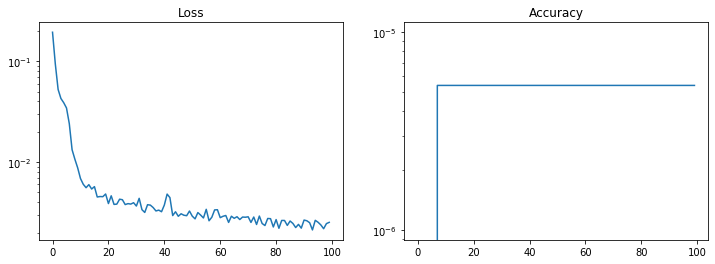

In [77]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].semilogy(h.history['loss'])
axes[0].set_title("Loss")
axes[1].semilogy(h.history['accuracy'])
axes[1].set_title("Accuracy")
plt.show()

# Get the Encoded and Decoded Spectra

In [69]:
encoded_imgs = encoder.predict(x_train)
decoded_imgs = ae.predict(x_train)

## Perform TSNE Embedding of the Encoded Spectra
Color coded by temperature (dark blue lowest, pink warmest)

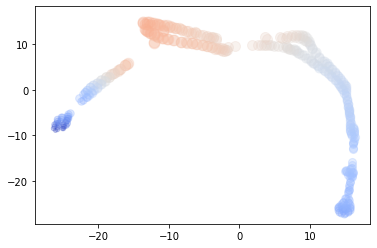

In [70]:
X_embedded = TSNE(n_components=2).fit_transform(encoded_imgs)

# Get a color map
cmap = plt.get_cmap('coolwarm')
min_temp = data['measured temp'].min()
max_temp = data['measured temp'].max()
color = lambda x: cmap(0.8 * (x - min_temp) / max_temp)

# Plot each graph
for rid, row in data.iterrows():
    plt.scatter(X_embedded[rid,0],
                X_embedded[rid,1], 
                color=color(row['measured temp']), 
                alpha=0.3, 
                s=row['measured temp']/2)
plt.savefig('./figures/4-ae-xrd-tsne.png', dpi=500)

# Examine the Embedded Layer for Each Spectra
Color coded by temperature (dark blue lowest, pink warmest)

<Figure size 2880x576 with 0 Axes>

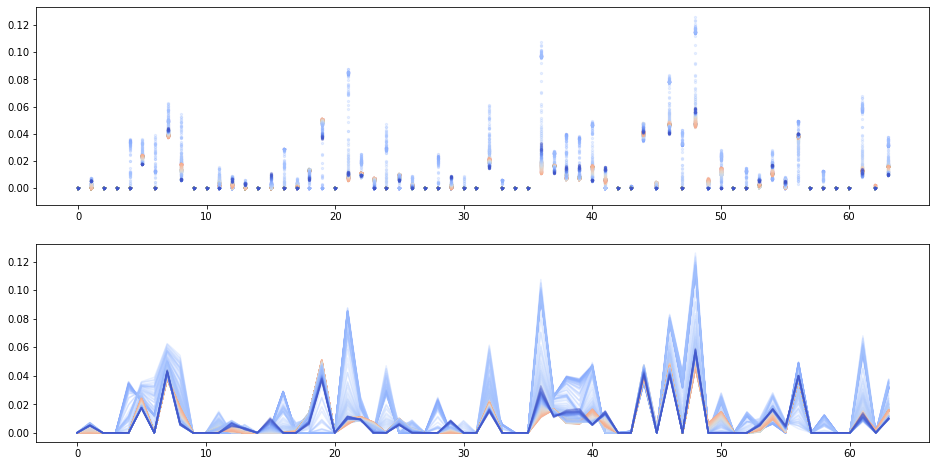

In [71]:
n = 10
plt.figure(figsize=(40, 8))
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

for rid, row in data.iterrows():
    axes[0].scatter(list(range(0,len(encoded_imgs[rid]))),
             encoded_imgs[rid], 
             color=color(row['measured temp']), s=5,
            alpha=0.25)
    
    axes[1].plot(list(range(0,len(encoded_imgs[rid]))),
             encoded_imgs[rid], 
             color=color(row['measured temp']),
            alpha=0.25)
plt.savefig('./figures/4-ae-xrd-composite.png', dpi=500)
plt.show()

# Show original and decoded images
Original (top - blue)
Decoded (bottom - red)

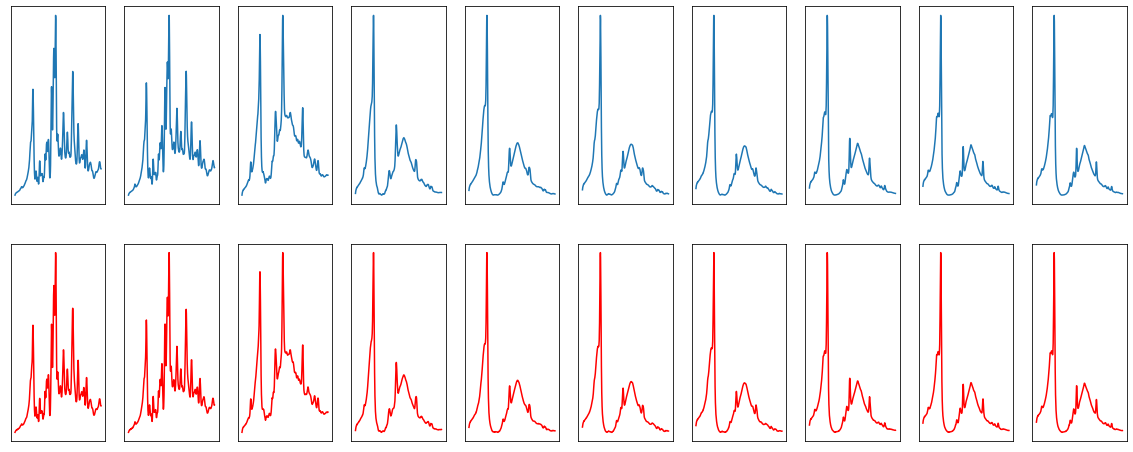

In [72]:
n = 10
indexes = np.arange(0,300, 30)
fig, axes = plt.subplots(2, n, figsize=(20,8))

for i, index in enumerate(indexes):
    # display original
    axes[0,i].plot(x_train[index]) 
    plt.gray()
    axes[0,i].get_xaxis().set_visible(False)
    axes[0,i].get_yaxis().set_visible(False)

    # display reconstruction
    axes[1,i].plot(decoded_imgs[index], color="red") 
    plt.gray()
    axes[1,i].get_xaxis().set_visible(False)
    axes[1,i].get_yaxis().set_visible(False)

plt.savefig('./figures/4-ae-xrd-compressed.png', dpi=500)
plt.show()